In [1]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier
import dice_ml
from dice_ml.utils import helpers # helper functions
from dice_ml import Data,Model,Dice
import numpy as np
from xgboost import XGBClassifier
import time
import threading
from joblib import Parallel, delayed
import os
import numpy as np
from dataLoader import DataLoader
from plotter import Plotter
from hyperParameterTuning import HyperparameterTuner
import pandas as pd



In [2]:

# Load dataset using DataLoader
dataLoader = DataLoader("heart_statlog_cleveland_hungary_final.csv")
df_cvd = dataLoader.load_data()
if df_cvd is not None:
    df_cvd = dataLoader.remove_outliers_iqr(df_cvd)

# Assuming the target column is named 'target'
X = df_cvd.drop(columns='target')
y = df_cvd['target']

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

numerical = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

categorical = X_train.columns.difference(numerical)


# We create the preprocessing pipelines for both numeric and categorical data.
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

transformations = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical),
        ('cat', categorical_transformer, categorical)])


pipeline = Pipeline(steps=[
('preprocessor', transformations),
('classifier', XGBClassifier())
])

# Define the parameter grid
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 6, 9],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0]
}

# Create the HyperparameterTuner instance
tuner = HyperparameterTuner(pipeline, param_grid)

# Perform hyperparameter tuning
best_params, best_score = tuner.tune(X_train, y_train)
print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Get the best estimator
best_model = tuner.get_best_estimator()
print("Best Estimator:", best_model)

Data loaded successfully.
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 200, 'classifier__subsample': 1.0}
Best Score: 0.8696690840881505
Best Estimator: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'trestbps', 'chol',
                                                   'thalach', 'oldpeak']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                

In [3]:
# Train the model with the best hyperparameters on the full training set
best_model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f"Test Accuracy: {accuracy}")
print(f"Test F1 Score: {f1}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")

Test Accuracy: 0.8873239436619719
Test F1 Score: 0.8873910127431254
Test Precision: 0.8906290632418693
Test Recall: 0.8873239436619719


In [5]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numerical = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

categorical = X_train.columns.difference(numerical)


# We create the preprocessing pipelines for both numeric and categorical data.
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

transformations = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical),
        ('cat', categorical_transformer, categorical)])


pipeline = Pipeline(steps=[('preprocessor', transformations),('classifier', XGBClassifier(max_depth=3, learning_rate=0.01, n_estimators=300, subsample=0.8,colsample_bytree=1.0))])



In [6]:
# train the model on the entire training set
xgb_pipeline = pipeline.fit(X_train, y_train)

# make predictions on the test set
y_pred = xgb_pipeline.predict(X_test)


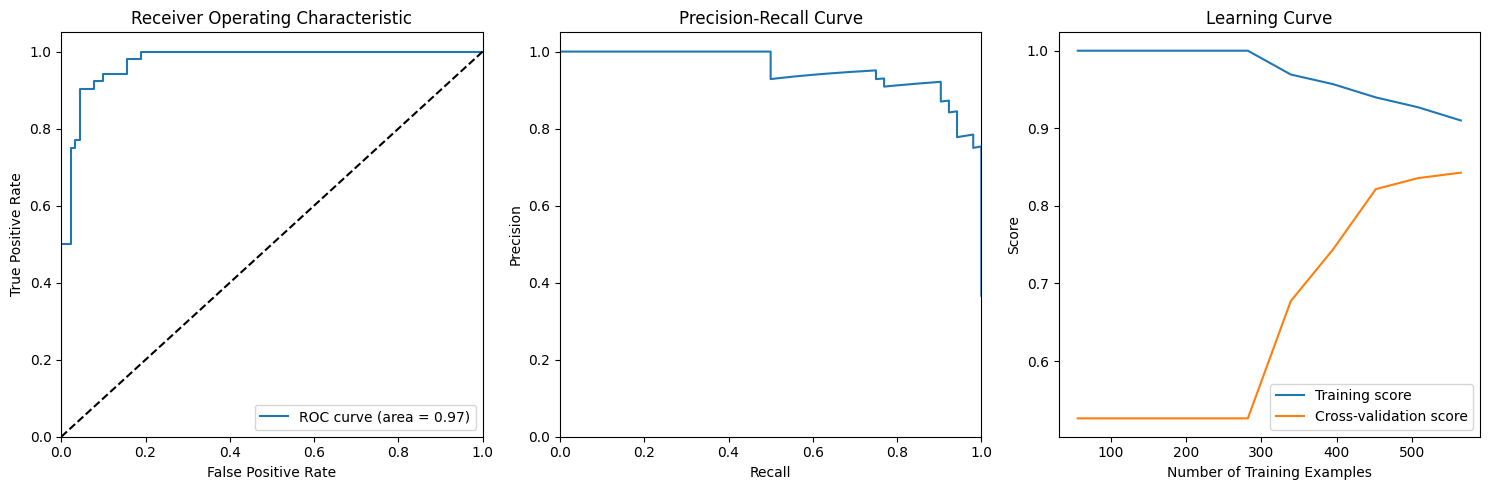

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc
from sklearn.model_selection import learning_curve

# Assuming pipeline is your trained classifier and X_test is your test data
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

# Compute the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Compute the Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

# Compute the learning curve
train_sizes, train_scores, test_scores = learning_curve(pipeline, X, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=5)
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

# Create a 1 by 3 grid of plots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Plot the ROC curve
ax1.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
ax1.plot([0, 1], [0, 1], 'k--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operating Characteristic')
ax1.legend(loc="lower right")

# Plot the Precision-Recall curve
ax2.plot(recall, precision)
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve')

# Plot the learning curve
ax3.plot(train_sizes, train_mean, label='Training score')
ax3.plot(train_sizes, test_mean, label='Cross-validation score')
ax3.set_xlabel('Number of Training Examples')
ax3.set_ylabel('Score')
ax3.set_title('Learning Curve')
ax3.legend(loc='best')

# Display the plots
plt.tight_layout()
plt.show()

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Make predictions on the training and test data
train_preds = pipeline.predict(X_train)
test_preds = pipeline.predict(X_test)

import pandas as pd

# Compute various classification metrics
metrics = {
    'Accuracy': [accuracy_score(y_train, train_preds), accuracy_score(y_test, test_preds)],
    'Precision': [precision_score(y_train, train_preds), precision_score(y_test, test_preds)],
    'Recall': [recall_score(y_train, train_preds), recall_score(y_test, test_preds)],
    'F1 Score': [f1_score(y_train, train_preds), f1_score(y_test, test_preds)],
    'ROC AUC Score': [roc_auc_score(y_train, train_preds), roc_auc_score(y_test, test_preds)]
}

# Create a DataFrame from the metrics
df_metrics = pd.DataFrame(metrics, index=['Train', 'Test'])

df_metrics.to_clipboard()

# Print the DataFrame
print(df_metrics)

       Accuracy  Precision    Recall  F1 Score  ROC AUC Score
Train  0.899115   0.886986  0.915194  0.900870       0.899087
Test   0.908451   0.842105  0.923077  0.880734       0.911538


In [6]:
X_high_risk_tp = X_test[(y_pred == 1) & (y_test == 1)].reset_index().drop(['index'], axis=1)
#X_high_risk_tp = X_test[(y_pred == 1) & (y_test == 1)]

In [7]:
train_data = pd.concat([X_train, y_train], axis=1)


# Create a DICE data object
d = Data(dataframe=pd.DataFrame(train_data, columns=df_cvd.columns), continuous_features=['age', 'trestbps', 'chol', 'thalach', 'oldpeak'],outcome_name='target')

# Create a DICE model object
m = Model(model=pipeline, backend="sklearn")

In [8]:
import threading
import queue
import concurrent.futures



def generate_cf_general(test_instance, timeout=30):
    q = queue.Queue()

    def target():
        try:
            result = Dice(d, m, method='genetic').generate_counterfactuals(test_instance, total_CFs=10, desired_class="opposite",
                                                                           #features_to_vary=["trestbps", "chol"],
                                                                           permitted_range={'trestbps': [100, 120], 'chol': [150, test_instance['chol'].values[0]-0.1*test_instance['chol'].values[0]]}
                                                                           #diversity_weight=5, proximity_weight=2, sparsity_weight=5
                                                                          )
            q.put(result)
        except Exception as e:
            print("No counterfactuals found for test instance:", test_instance)
            #df_no_counterfactuals.append(test_instance)
            q.put(None)

    # Start a new thread to run the target function
    thread = threading.Thread(target=target)
    thread.start()

    # Wait for the thread to finish or raise a timeout exception
    thread.join(timeout)

    if thread.is_alive():
        # The thread is still running, so raise a timeout exception
        print("No counterfactuals found for test instance-timed out:", test_instance)
        #df_no_counterfactuals.append(test_instance)
        q.put(None)
    else:
        # The thread has finished, so return the result
        return q.get()

In [9]:
exps_general= []
num_cores = -1
df_no_counterfactuals_general= pd.DataFrame(columns=X_high_risk_tp.columns)
# Iterate over each instance of X_high_risk and generate counterfactuals
for i in range(len(X_high_risk_tp)):
    test_instance = X_high_risk_tp.iloc[[i]]
    print(i)   
    exp = Parallel(n_jobs=num_cores)(delayed(generate_cf_general)(test_instance) for i in range(1))
    exps_general.append(exp)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47


In [27]:
exps_general[0]

[None]

In [48]:
num_none = sum(exp[0] is None for exp in exps_general)
print("Number of None values in exps_general:", num_none)

Number of None values in exps_general: 1


In [12]:
query_instance = X_high_risk_tp.iloc[0:1]


In [14]:
cf_df = exps_general[0][0].cf_examples_list[0]

In [15]:
print(query_instance)

   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope
0   58    1   4       136   203    1        0      123      1      1.2      2


In [16]:
# Print the entire DataFrame
cf_df.visualize_as_dataframe()

Query instance (original outcome : 1)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,target
0,58,1,4,136,203,1,0,123,1,1.2,2,1



Diverse Counterfactual set (new outcome: 0)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,target
0,39,1,2,120,170,0,0,160,1,1.0,2,0
0,28,1,2,100,172,1,0,170,0,1.0,2,0
0,28,1,3,100,150,1,0,170,1,1.0,0,0
0,52,1,4,125,176,0,0,168,0,1.0,1,0


In [24]:
exp_df = exps_general[0][0].cf_examples_list[0].final_cfs_df

In [25]:
exp_df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,target
0,39,1,2,120,170,0,0,160,1,1.0,2,0
0,28,1,2,100,172,1,0,170,0,1.0,2,0
0,28,1,3,100,150,1,0,170,1,1.0,0,0
0,52,1,4,125,176,0,0,168,0,1.0,1,0


In [26]:
import pandas as pd

# Get original instance
original_instance = X_high_risk_tp.iloc[0:1].copy()

# Extract the counterfactual dataframe
cf_df = exps_general[0][0].cf_examples_list[0].final_cfs_df


# Extract chol and trestbps values
cf_values = cf_df[['chol', 'trestbps']]

# Create new dataframe to store imputed instances
imputed_instances = pd.DataFrame()

# Add original instance as first row for reference
imputed_instances = pd.concat([imputed_instances, original_instance], ignore_index=True)

# Create new rows by imputing counterfactual values into original instance
for i, row in cf_values.iterrows():
    # Create a copy of the original instance
    new_instance = original_instance.copy()
    
    # Update with counterfactual values
    new_instance['chol'] = row['chol']
    new_instance['trestbps'] = row['trestbps']
    
    # Add to the imputed instances dataframe
    imputed_instances = pd.concat([imputed_instances, new_instance], ignore_index=True)

# Display the results
print("Original instance:")
print(original_instance)
print("\nCounterfactual values (chol, trestbps):")
print(cf_values)
print("\nImputed instances:")
print(imputed_instances)

Original instance:
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope
0   58    1   4       136   203    1        0      123      1      1.2      2

Counterfactual values (chol, trestbps):
   chol  trestbps
0   170       120
0   172       100
0   150       100
0   176       125

Imputed instances:
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope
0   58    1   4       136   203    1        0      123      1      1.2      2
1   58    1   4       120   170    1        0      123      1      1.2      2
2   58    1   4       100   172    1        0      123      1      1.2      2
3   58    1   4       100   150    1        0      123      1      1.2      2
4   58    1   4       125   176    1        0      123      1      1.2      2


In [27]:
import pandas as pd
import os

# Create directories if they don't exist
os.makedirs("original", exist_ok=True)
os.makedirs("counterfactuals", exist_ok=True)

# Iterate through all instances
for i in range(len(exps_general)):
    # Skip if the experiment resulted in None (no counterfactuals found)
    if exps_general[i] is None or len(exps_general[i]) == 0 or exps_general[i][0] is None:
        print(f"Skipping instance {i} - no counterfactuals found")
        continue
        
    try:
        # Get original instance
        original_instance = X_high_risk_tp.iloc[[i]].copy()
        
        # Try to extract the counterfactual dataframe
        cf_df = exps_general[i][0].cf_examples_list[0].final_cfs_df
        
        # Extract chol and trestbps values
        cf_values = cf_df[['chol', 'trestbps']]
        
        # Create new dataframe to store imputed instances
        imputed_instances = pd.DataFrame()
        
        # Add original instance as first row for reference
        imputed_instances = pd.concat([imputed_instances, original_instance], ignore_index=True)
        
        # Create new rows by imputing counterfactual values into original instance
        for j, row in cf_values.iterrows():
            # Create a copy of the original instance
            new_instance = original_instance.copy()
            
            # Update with counterfactual values
            new_instance['chol'] = row['chol']
            new_instance['trestbps'] = row['trestbps']
            
            # Add to the imputed instances dataframe
            imputed_instances = pd.concat([imputed_instances, new_instance], ignore_index=True)
        
        # Save original instance to CSV
        original_file = f"original/{i}_original.csv"
        original_instance.to_csv(original_file, index=False)
        
        # Save counterfactual instances to CSV
        counterfactual_file = f"counterfactuals/{i}_counterfactual.csv"
        imputed_instances.to_csv(counterfactual_file, index=False)
        
        print(f"Processed instance {i} - saved {original_file} and {counterfactual_file}")
    
    except Exception as e:
        print(f"Error processing instance {i}: {e}")

Processed instance 0 - saved original/0_original.csv and counterfactuals/0_counterfactual.csv
Processed instance 1 - saved original/1_original.csv and counterfactuals/1_counterfactual.csv
Processed instance 2 - saved original/2_original.csv and counterfactuals/2_counterfactual.csv
Processed instance 3 - saved original/3_original.csv and counterfactuals/3_counterfactual.csv
Processed instance 4 - saved original/4_original.csv and counterfactuals/4_counterfactual.csv
Processed instance 5 - saved original/5_original.csv and counterfactuals/5_counterfactual.csv
Processed instance 6 - saved original/6_original.csv and counterfactuals/6_counterfactual.csv
Processed instance 7 - saved original/7_original.csv and counterfactuals/7_counterfactual.csv
Processed instance 8 - saved original/8_original.csv and counterfactuals/8_counterfactual.csv
Processed instance 9 - saved original/9_original.csv and counterfactuals/9_counterfactual.csv
Processed instance 10 - saved original/10_original.csv and c

In [28]:
import pandas as pd
import os

# Create directories if they don't exist
os.makedirs("original", exist_ok=True)
os.makedirs("counterfactuals", exist_ok=True)

# Iterate through all instances
for i in range(len(exps_general)):
    # Skip if the experiment resulted in None (no counterfactuals found)
    if exps_general[i] is None or len(exps_general[i]) == 0 or exps_general[i][0] is None:
        print(f"Skipping instance {i} - no counterfactuals found")
        continue
        
    try:
        # Get original instance
        original_instance = X_high_risk_tp.iloc[[i]].copy()
        
        # Try to extract the counterfactual dataframe
        cf_df = exps_general[i][0].cf_examples_list[0].final_cfs_df
        
        # Extract chol and trestbps values
        cf_values = cf_df[['chol', 'trestbps']]
        
        # Create new dataframe to store imputed instances (counterfactuals only)
        imputed_instances = pd.DataFrame()
        
        # Create new rows by imputing counterfactual values into original instance
        for j, row in cf_values.iterrows():
            # Create a copy of the original instance
            new_instance = original_instance.copy()
            
            # Update with counterfactual values
            new_instance['chol'] = row['chol']
            new_instance['trestbps'] = row['trestbps']
            
            # Add to the imputed instances dataframe
            imputed_instances = pd.concat([imputed_instances, new_instance], ignore_index=True)
        
        # Save original instance to CSV
        original_file = f"original/{i}_original.csv"
        original_instance.to_csv(original_file, index=False)
        
        # Save counterfactual instances to CSV (without the original)
        counterfactual_file = f"counterfactuals/{i}_counterfactual.csv"
        imputed_instances.to_csv(counterfactual_file, index=False)
        
        print(f"Processed instance {i} - saved {original_file} and {counterfactual_file}")
    
    except Exception as e:
        print(f"Error processing instance {i}: {e}")

Processed instance 0 - saved original/0_original.csv and counterfactuals/0_counterfactual.csv
Processed instance 1 - saved original/1_original.csv and counterfactuals/1_counterfactual.csv
Processed instance 2 - saved original/2_original.csv and counterfactuals/2_counterfactual.csv
Processed instance 3 - saved original/3_original.csv and counterfactuals/3_counterfactual.csv
Processed instance 4 - saved original/4_original.csv and counterfactuals/4_counterfactual.csv
Processed instance 5 - saved original/5_original.csv and counterfactuals/5_counterfactual.csv
Processed instance 6 - saved original/6_original.csv and counterfactuals/6_counterfactual.csv
Processed instance 7 - saved original/7_original.csv and counterfactuals/7_counterfactual.csv
Processed instance 8 - saved original/8_original.csv and counterfactuals/8_counterfactual.csv
Processed instance 9 - saved original/9_original.csv and counterfactuals/9_counterfactual.csv
Processed instance 10 - saved original/10_original.csv and c